## Lab 7, Group 1
### Names: Hailey DeMark, Deborah Park, Karis Park
### Student IDs: 48869449, 48878679, 48563429

Dataset:

## Preparation (3 points total)
* [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  

    * For this lab, we used an E-mail Classification NLP dataset, which contains short email messages labeled as either "spam" or "non-spam". The dataset is already split into two parts: a training set with 957 messages and a test set with 125 messages. Each row in the data has a message and a label. The two key columns in the dataset are "message_body" and "label". The message body column contains the body of the email in text, and the label column either classifies the message body as spam or non-spam. The label column will be used as the classification target. 
    * We will convert the Label column into binary format using LabelEncoder. This transformation will allow us to treat the task as a binary classification problem: 
        * "Spam" = 1 
        * "Non-Spam" = 0   
    * To prepare the messages, we will use a tokenizer to turn each message into a list of numbers. We will convert all text to lowercase to normalize word representations and reduce vocab size. Then, we will tokenize the messages to remove punctuation and only capture alphanumeric tokens. Finally, we will make all messages the same length by adding padding, so they can be used in a neural network.
    
      

* [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
    * We used the Keras tokenizer to convert the text into sequences of integers, where each unique word is mapped to a unique index. This numerical representation makes it easier for the model to process and train efficiently. Since our goal is to determine whether a message is spam or not, preserving the order of words is essential—word position can influence meaning. The tokenizer allows us to maintain this word order through indexed sequences. Additionally, we applied padding to ensure all sequences have the same length, which provides consistent input dimensions and improves the model’s processing efficiency.

* [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.
    * We used a shuffle-and-split method to divide the dataset. This approach was chosen because it is efficient and helps ensure a balanced distribution of spam and non-spam messages across the training and validation sets. By randomly mixing the data before splitting, we avoid having large sections dominated by only one class, which can lead to biased or ineffective models. This improves the model's ability to accurately predict whether a given message is spam or not. For evaluation, we selected the F1-score as our primary metric. Since the dataset is imbalanced—with significantly more spam than non-spam messages—the F1-score provides a better measure than accuracy by balancing both precision and recall. This is especially important in real-world scenarios: if important legitimate emails are mistakenly flagged as spam, they might be lost or ignored, causing real harm. On the other hand, misclassifying spam as legitimate is usually just inconvenient. Therefore, it's crucial to strike a balance between catching as much spam as possible while minimizing false positives.ng data. This helps us get a better idea of how the model performs, especially when the number of spam and normal messages are very different.

In [1]:
!pip3 install tensorflow-hub
# !pip install nltk

import tensorflow_hub as hub
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import MultiHeadAttention, Flatten, Input, Embedding, Dense, GlobalMaxPooling1D, Dropout, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load data
dfTrain = pd.read_csv('SMS_train.csv', encoding='cp1252')
dfTest = pd.read_csv('SMS_test.csv', encoding='cp1252')

# Combine the datasets
dfCombined = pd.concat([dfTrain, dfTest], ignore_index=True)

dfCombined.head()
dfCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        1082 non-null   int64 
 1   Message_body  1082 non-null   object
 2   Label         1082 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.5+ KB


In [3]:
import re
import nltk
from nltk.corpus import stopwords


# Download the stopwords resource if not already done
nltk.download('stopwords')

# Get the English stopwords set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Simpler tokenization using regular expressions
def simple_tokenizer(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and tokenize by splitting on spaces
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Apply the simple tokenizer to the Message_body column
dfCombined['Processed_Message'] = dfCombined['Message_body'].apply(simple_tokenizer).apply(remove_stopwords)

# Encode the Labels into binary format (Spam=1, Non-Spam=0)
label_encoder = LabelEncoder()
dfCombined['Encoded_Label'] = label_encoder.fit_transform(dfCombined['Label'])

# Display a sample of the processed dataset
dfCombined[['Message_body', 'Processed_Message', 'Label', 'Encoded_Label']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haileydemark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Message_body,Processed_Message,Label,Encoded_Label
0,Rofl. Its true to its name,"[rofl, true, name]",Non-Spam,0
1,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, interested, buyin...",Non-Spam,0
2,"Pity, * was in mood for that. So...any other s...","[pity, mood, suggestions]",Non-Spam,0
3,Will ü b going to esplanade fr home?,"[ü, b, going, esplanade, fr, home]",Non-Spam,0
4,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, 2, contact, u, u, 750, poun...",Spam,1


In [4]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfCombined['Processed_Message'].apply(lambda x: ' '.join(x)))

# Convert text to integer sequences
sequences = tokenizer.texts_to_sequences(dfCombined['Processed_Message'].apply(lambda x: ' '.join(x)))

# Pad sequences
padded_sequences = pad_sequences(sequences, padding='post')

# Vocabulary size for the embedding layer
vocab_size = len(tokenizer.word_index) + 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, dfCombined['Encoded_Label'], test_size=0.2, random_state=42
)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Modeling (6 points total)
* [3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7218 - loss: 0.6737 - val_accuracy: 0.7861 - val_loss: 0.5236
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8262 - loss: 0.4704 - val_accuracy: 0.7861 - val_loss: 0.5150
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8049 - loss: 0.4883 - val_accuracy: 0.7861 - val_loss: 0.5141
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8273 - loss: 0.4315 - val_accuracy: 0.7861 - val_loss: 0.4361
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8553 - loss: 0.3303 - val_accuracy: 0.9422 - val_loss: 0.1717
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9882 - loss: 0.0658 - val_accuracy: 0.9480 - val_loss: 0.1279
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0115 - val_accuracy: 0.9595 - val_loss: 0.1078
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9653 - val_loss: 0.1166
Epo

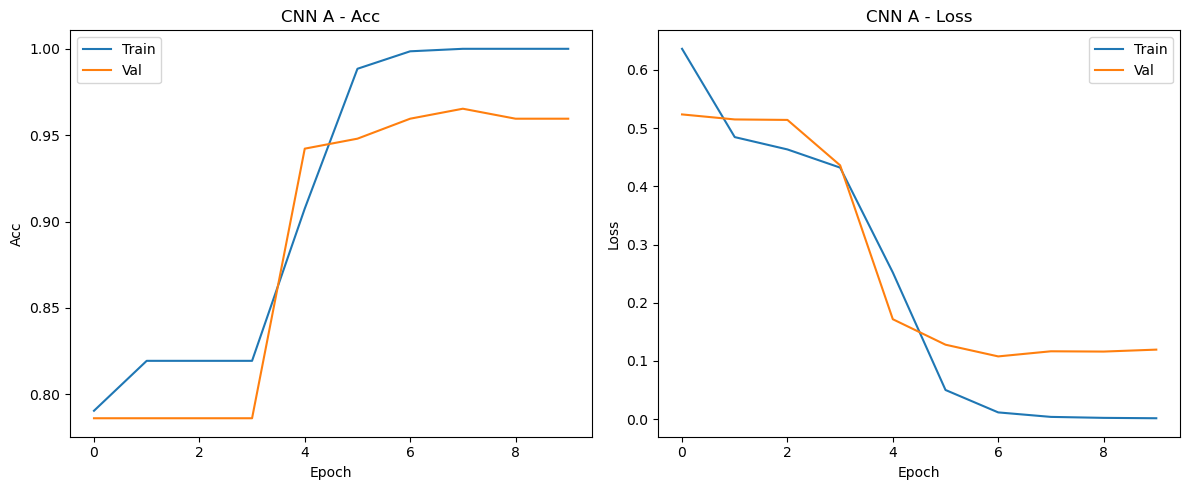

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
F1 A: 0.9041095890410958
Conf A:
 [[177   4]
 [  3  33]]
Prec A: 0.8918918918918919
Rec A: 0.9166666666666666
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8216 - loss: 0.4703 - val_accuracy: 0.8497 - val_loss: 0.2867
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 0.1498 - val_accuracy: 0.9306 - val_loss: 0.1649
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0428 - val_accuracy: 0.9538 - val_loss: 0.1287
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9949 - loss: 0.0197 - val_accuracy: 0.9653 - val_loss: 0.1212
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9595 - val_loss: 0.1271
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9653 - val_loss: 0.1258
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accura

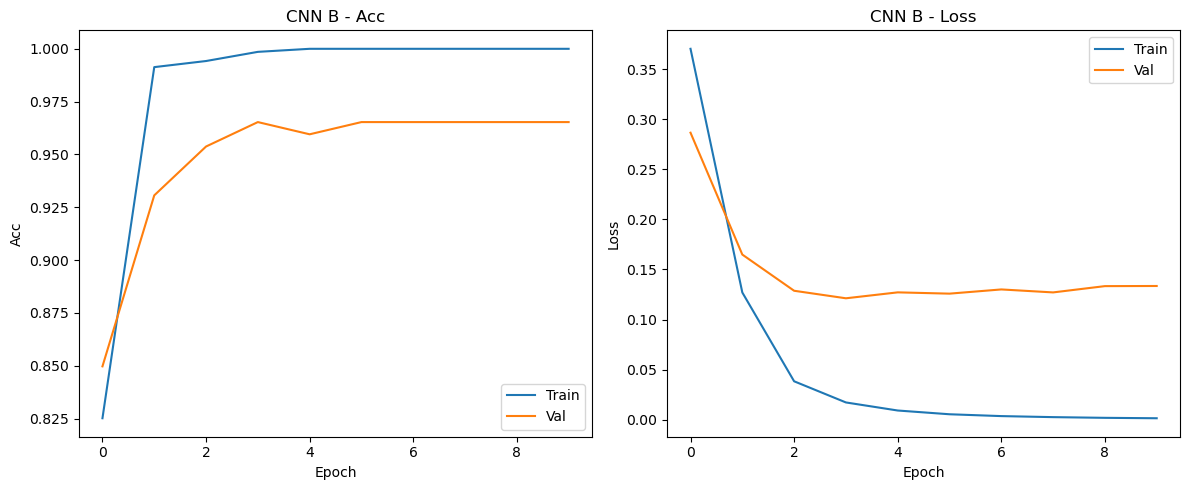

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
F1 B: 0.8888888888888888
Conf B:
 [[177   4]
 [  4  32]]
Prec B: 0.8888888888888888
Rec B: 0.8888888888888888


In [6]:
# CNN
# Plot training results
def plot_metrics(hist, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Val')
    plt.title(f'{title} - Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Input
inp = Input(shape=(X_train.shape[1],))
emb = Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1])(inp)

# CNN A
conv1 = Conv1D(128, 5, activation='relu')(emb)
drop1 = Dropout(0.4)(conv1)
pool1 = GlobalMaxPooling1D()(conv1)
dense1 = Dense(10, activation='relu')(pool1)
out1 = Dense(1, activation='sigmoid')(dense1)

model1 = Model(inputs=inp, outputs=out1)
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train A
hist1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
plot_metrics(hist1, "CNN A")

# Eval A
pred1 = (model1.predict(X_test) > 0.5).astype(int)
print("F1 A:", f1_score(y_test, pred1))
print("Conf A:\n", confusion_matrix(y_test, pred1))
print("Prec A:", precision_score(y_test, pred1))
print("Rec A:", recall_score(y_test, pred1))

# CNN B
conv2 = Conv1D(64, 3, activation='relu')(emb)
drop2 = Dropout(0.4)(conv2)
pool2 = GlobalMaxPooling1D()(conv2)
dense2 = Dense(20, activation='relu')(pool2)
out2 = Dense(1, activation='sigmoid')(dense2)

model2 = Model(inputs=inp, outputs=out2)
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train B
hist2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
plot_metrics(hist2, "CNN B")

# Eval B
pred2 = (model2.predict(X_test) > 0.5).astype(int)
print("F1 B:", f1_score(y_test, pred2))
print("Conf B:\n", confusion_matrix(y_test, pred2))
print("Prec B:", precision_score(y_test, pred2))
print("Rec B:", recall_score(y_test, pred2))


In our CNN arcitecture, we created two CNN variants, CNN A and CNN B. In CNN A, we used 128 filters, had a kernel size of 5, a dropout rate of 0.4, and an output dimension of emedding of 128. For CNN B, the only parameters we changed were the amount of filters and the kernel size (64 filters and a kernel size of 3). CNN B has smaller and fewer filters. We found that increasing the number of filters improved the model's ability to extract features from text sequences, while reducing them in CNN B tested whether tested whether a smaller architecture could generalize better with fewer parameters. In our visualization of CNN A, we can see that it reached a validation accuracy of 97.11%, while the validation loss plateued. CNN B maintained a slightly lower accuracy than CNN A, but demonstarted a more balanced precision and recall. 

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8038 - loss: 0.5354 - val_accuracy: 0.7861 - val_loss: 0.5221
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8079 - loss: 0.4514 - val_accuracy: 0.7861 - val_loss: 0.4296
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8115 - loss: 0.3500 - val_accuracy: 0.9653 - val_loss: 0.1141
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9787 - loss: 0.0601 - val_accuracy: 0.9711 - val_loss: 0.1113
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9906 - loss: 0.0241 - val_accuracy: 0.9769 - val_loss: 0.1238
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9938 - loss: 0.0111 - val_accuracy: 0.9769 - val_loss: 0.1235
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 9.5829e-04 - val_accuracy: 0.9769 - val_loss: 0.1314
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9769

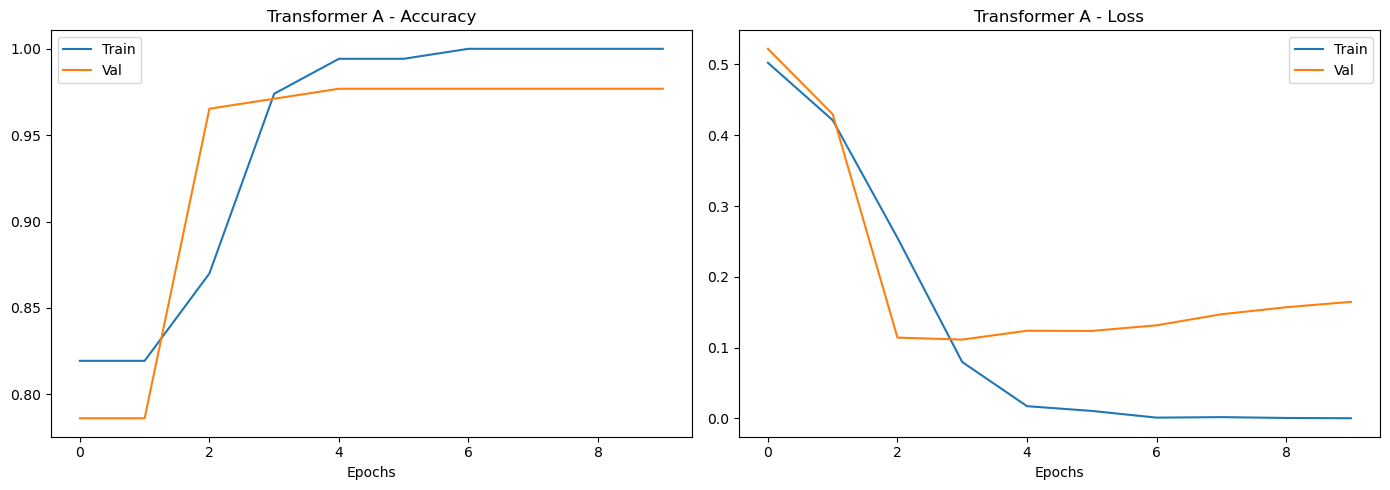

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7252 - loss: 0.5375 - val_accuracy: 0.7861 - val_loss: 0.6306
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8206 - loss: 0.4470 - val_accuracy: 0.7861 - val_loss: 0.4411
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9212 - loss: 0.1734 - val_accuracy: 0.9364 - val_loss: 0.1797
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9835 - loss: 0.0346 - val_accuracy: 0.9538 - val_loss: 0.4327
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9914 - loss: 0.0480 - val_accuracy: 0.9595 - val_loss: 0.2079
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9980 - loss: 0.0063 - val_accuracy: 0.9769 - val_loss: 0.3524
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9963 - loss: 0.0041 - val_accuracy: 0.9769 - val_loss: 0.3891
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9711 - v

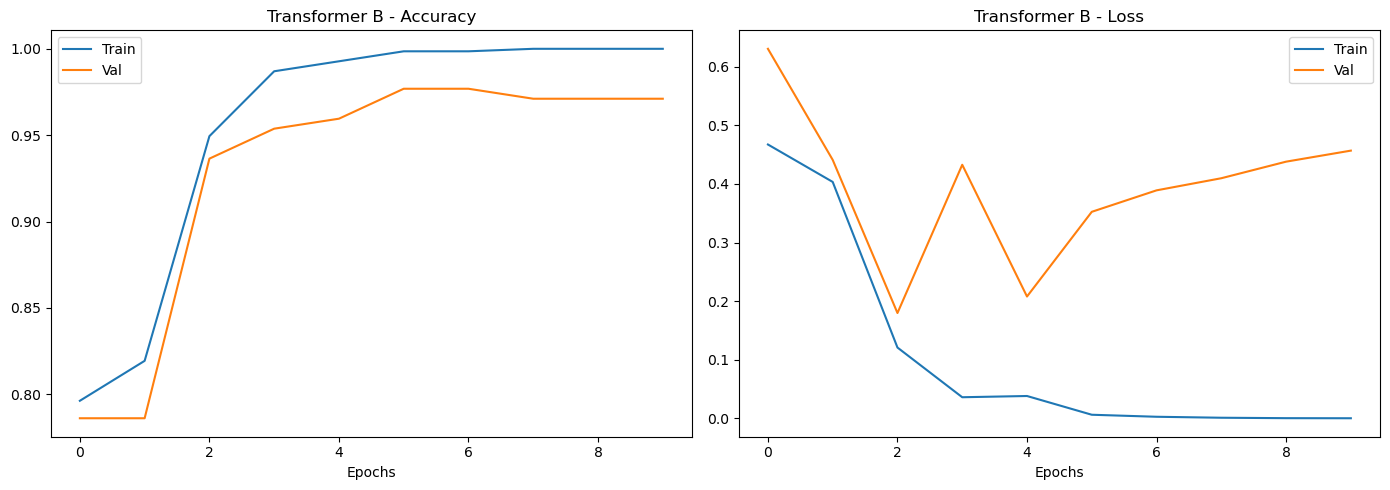

In [14]:
# Transformer

# Prepare 
train_texts = [str(t) for t in (X_train.tolist() if isinstance(X_train, np.ndarray) else X_train)]
test_texts = [str(t) for t in (X_test.tolist() if isinstance(X_test, np.ndarray) else X_test)]

# Tokenize
tok = Tokenizer()
tok.fit_on_texts(train_texts)
train_seq = tok.texts_to_sequences(train_texts)
test_seq = tok.texts_to_sequences(test_texts)
vocab = len(tok.word_index) + 1
max_len = max(len(seq) for seq in train_seq)

# Pad
X_train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_seq, maxlen=max_len, padding='post')

# Transformer A
def transformer_a(heads=4, dim=100):
    inp = Input(shape=(max_len,))
    emb = Embedding(input_dim=vocab, output_dim=dim)(inp)
    attn = MultiHeadAttention(num_heads=heads, key_dim=dim)(emb, emb)
    flat = Flatten()(attn)
    dense = Dense(10, activation='relu')(flat)
    out = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_a = transformer_a()
hist_a = model_a.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict & evaluate
pred_a = (model_a.predict(X_test_pad) > 0.5).astype(int)
print("F1 A:", f1_score(y_test, pred_a))
print("Conf A:\n", confusion_matrix(y_test, pred_a))
print("Prec A:", precision_score(y_test, pred_a))
print("Rec A:", recall_score(y_test, pred_a))

# Plot A
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(hist_a.history['accuracy'], label='Train')
ax[0].plot(hist_a.history['val_accuracy'], label='Val')
ax[0].set_title('Transformer A - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(hist_a.history['loss'], label='Train')
ax[1].plot(hist_a.history['val_loss'], label='Val')
ax[1].set_title('Transformer A - Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.tight_layout()
plt.show()

# Transformer B
def transformer_b(heads=6, dim=200):
    inp = Input(shape=(max_len,))
    emb = Embedding(input_dim=vocab, output_dim=dim)(inp)
    attn = MultiHeadAttention(num_heads=heads, key_dim=dim)(emb, emb)
    flat = Flatten()(attn)
    dense = Dense(10, activation='relu')(flat)
    out = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_b = transformer_b()
hist_b = model_b.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict & evaluate B
pred_b = (model_b.predict(X_test_pad) > 0.5).astype(int)
print("F1 B:", f1_score(y_test, pred_b))
print("Conf B:\n", confusion_matrix(y_test, pred_b))
print("Prec B:", precision_score(y_test, pred_b))
print("Rec B:", recall_score(y_test, pred_b))

# Plot B
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(hist_b.history['accuracy'], label='Train')
ax[0].plot(hist_b.history['val_accuracy'], label='Val')
ax[0].set_title('Transformer B - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(hist_b.history['loss'], label='Train')
ax[1].plot(hist_b.history['val_loss'], label='Val')
ax[1].set_title('Transformer B - Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.tight_layout()
plt.show()

For our Transformer architecture, Transformer A had 4 attention heads and an embedding output dimension of 100, while Transformer B had 6 attention heads and an embedding output dimension of 200. We found that transformer A achieved the highest F1-score of 0.9315, as well as consistently high precision of 0.9181 and recall of 0.9444. Its validation loss remained low and stable after the initial few epochs and its validation accuracy plateaued at 97.69%. Transformer B was also strong, achieving a slightly lower F1-score of 0.8947. It had strong recall, but lower precision than transformer A. Its validation loss showed more fluctuation and trended higher across later epochs, which could suggest overfitting even though its training performance was nearly perfect. These results indicate that transformer A generalizes better on unseen data, annd this model learned effectively while avoiding overfitting. So, transformer A is the superiod model based on F1-score, precision, and validation loss consistency. We will use the parameters for transformer A in our multi-headed attention layer in the code below. 

* [1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.. 

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7625 - loss: 0.5775 - val_accuracy: 0.7861 - val_loss: 0.4934
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8120 - loss: 0.4650 - val_accuracy: 0.7861 - val_loss: 0.4332
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8494 - loss: 0.3420 - val_accuracy: 0.9422 - val_loss: 0.1831
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9648 - loss: 0.1116 - val_accuracy: 0.9653 - val_loss: 0.0948
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9878 - loss: 0.0357 - val_accuracy: 0.9653 - val_loss: 0.1904
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9873 - loss: 0.0377 - val_accuracy: 0.9711 - val_loss: 0.1416
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9980 - loss: 0.0057 - val_accuracy: 0.9769 - val_loss: 0.1924
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9769 - v

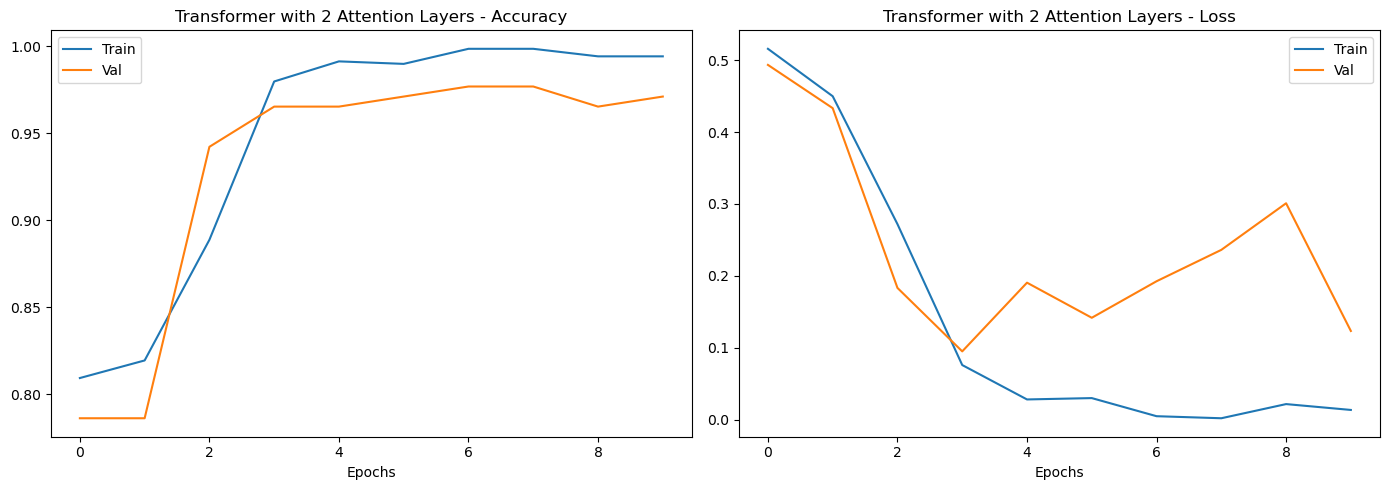

In [18]:
from keras.callbacks import EarlyStopping

def transformer_with_two_attention_layers(vocab_size, max_len, heads=4, dim=100):
    inp = Input(shape=(max_len,))
    emb = Embedding(input_dim=vocab_size, output_dim=dim)(inp)

    # first multi-head attention
    attn1 = MultiHeadAttention(num_heads=heads, key_dim=dim)(emb, emb)

    # second multi-head attention (takes output of first)
    attn2 = MultiHeadAttention(num_heads=heads, key_dim=dim)(attn1, attn1)

    # final layers
    flat = Flatten()(attn2)
    dense = Dense(64, activation='relu')(flat)
    drop = Dropout(0.2)(dense)
    out = Dense(1, activation='sigmoid')(drop)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Setup early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)       # if you want to test w 10 epochs instead of early stopping, comment this line out 

# train model
model = transformer_with_two_attention_layers(vocab_size, max_len)
hist = model.fit(X_train_pad, y_train,
                 epochs=10,
                 batch_size=32,
                 validation_split=0.2,
                #  callbacks=[early_stop],        # also comment this line out to test with 10 epochs instead of early stopping 
                 verbose=1)

# evaluate
preds = (model.predict(X_test_pad) > 0.5).astype(int)
print("F1:", f1_score(y_test, preds))
print("Confusion matrix:\n", confusion_matrix(y_test, preds))
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))

# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# accuracy
ax[0].plot(hist.history['accuracy'], label='Train')
ax[0].plot(hist.history['val_accuracy'], label='Val')
ax[0].set_title('Transformer with 2 Attention Layers - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()

# loss
ax[1].plot(hist.history['loss'], label='Train')
ax[1].plot(hist.history['val_loss'], label='Val')
ax[1].set_title('Transformer with 2 Attention Layers - Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

* [2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  


Model Score Comparison:
                  Model      F1  Precision  Recall  F1 Rank  Precision Rank  \
2         Transformer A  0.9315     0.9189  0.9444      2.0             2.0   
4  Transformer + 2 Attn  0.9427     0.9705  0.9166      1.0             1.0   
0                 CNN A  0.9041     0.8918  0.9166      3.0             3.0   
3         Transformer B  0.8947     0.8500  0.9444      4.0             5.0   
1                 CNN B  0.8888     0.8888  0.8888      5.0             4.0   

   Recall Rank  Avg Rank  
2          1.5  1.833333  
4          3.5  1.833333  
0          3.5  3.166667  
3          1.5  3.500000  
1          5.0  4.666667  


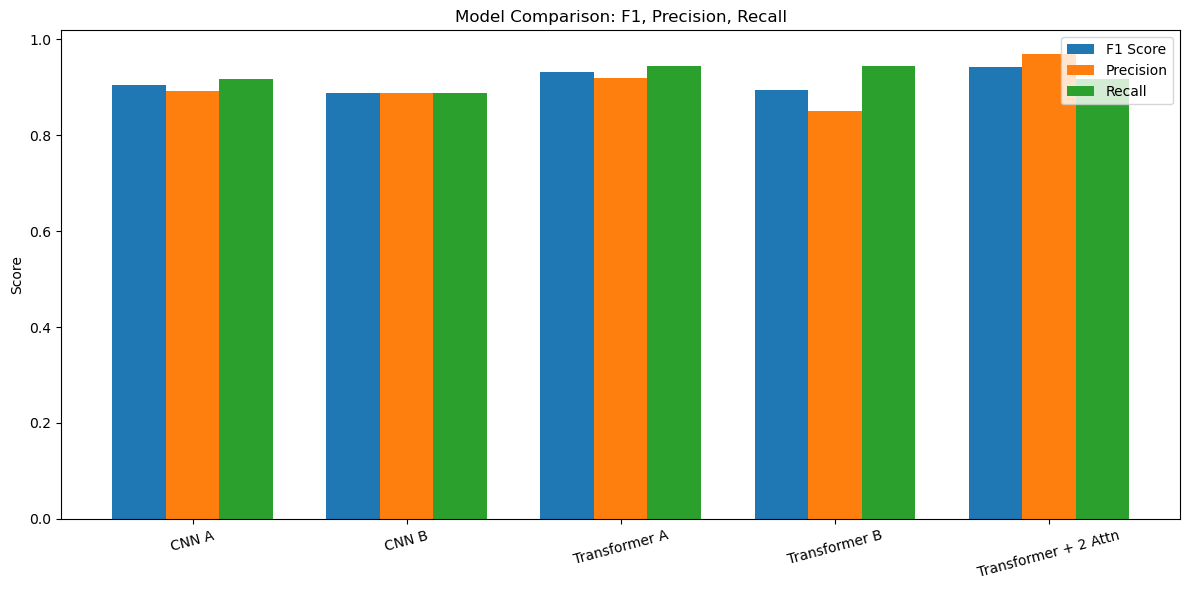

In [22]:
models = ["CNN A", "CNN B", "Transformer A", "Transformer B", "Transformer + 2 Attn"]

f1_scores = [0.9041, 0.8888, 0.9315, 0.8947, 0.9427]
precision_scores = [0.8918, 0.8888, 0.9189, 0.85, 0.9705]
recall_scores = [0.9166, 0.8888, 0.9444, 0.9444, 0.9166]

# create table 
data = pd.DataFrame({
    'Model': models,
    'F1': f1_scores,
    'Precision': precision_scores,
    'Recall': recall_scores
})

# ranking models 
data['F1 Rank'] = data['F1'].rank(ascending=False)
data['Precision Rank'] = data['Precision'].rank(ascending=False)
data['Recall Rank'] = data['Recall'].rank(ascending=False)
data['Avg Rank'] = data[['F1 Rank', 'Precision Rank', 'Recall Rank']].mean(axis=1)

# display table 
print("\nModel Score Comparison:")
print(data.sort_values('Avg Rank'))

# visualization 
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, f1_scores, width, label='F1 Score')
ax.bar(x, precision_scores, width, label='Precision')
ax.bar(x + width, recall_scores, width, label='Recall')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: F1, Precision, Recall')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

plt.tight_layout()
plt.show()

Based on the comparison chart and the graph, the transformer with 2 attention layers and transformer A performed the best. Both of these models achieved the lowest average rank of 1.83. Although transformer + 2 attention had the highest individual F1 and precision scores, transformer A had a slightly better recall. However, transformer + 2 attention is the best model overall since we are using the F1 score as our primary metric due to class imbalance. Even though all of the models performed well, the performance of transformer-based models surpasses the CNN based models (CNN A and B). The CNN models had lower average ranks and noticeably lower recall. The consistent results we got across all metrics and models, and telling from the visualization above, also shows that our transformer with 2 attention layers is the most effective architecture for determining spam from non-spam emails.  

## Exceptional Work (1 points total)
* You have free reign to provide additional analyses.
* One idea (required for 7000 level students to do one of these options):
    * Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 

In [11]:
# code